In [1]:
import math
import numpy as np
import scipy.special
import torch
import torch.distributions as distributions
import torch.nn.functional as F

In [2]:
# Common
ln_2: torch.Tensor = math.log(2)
ln_pi: torch.Tensor = math.log(math.pi)
ln_2pi: torch.Tensor = ln_2 + ln_pi
eps = 1e-8

    
class LeakyClamp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, min, max):
        ctx.save_for_backward(x.ge(min) * x.le(max))
        return torch.clamp(x, min=min, max=max)

    @staticmethod
    def backward(ctx, grad_output):
        mask, = ctx.saved_tensors
        mask = mask.type_as(grad_output)
        return grad_output * mask + grad_output * (1 - mask) * eps, None, None


def clamp(x: torch.Tensor, min: float = float("-inf"), max: float = float("+inf")) -> torch.Tensor:
    return LeakyClamp.apply(x, min, max)


def sqrt(x: torch.Tensor):
    x = clamp(x, min=1e-9)
    return torch.sqrt(x)


class IveFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, v, z):
        ctx.save_for_backward(z)
        ctx.v = v
        z_cpu = z.double().detach().cpu().numpy()
        if np.isclose(v, 0):
            output = scipy.special.i0e(z_cpu, dtype=z_cpu.dtype)
        elif np.isclose(v, 1):
            output = scipy.special.i1e(z_cpu, dtype=z_cpu.dtype)
        else:
            output = scipy.special.ive(v, z_cpu, dtype=z_cpu.dtype)
        return torch.tensor(output, dtype=z.dtype, device=z.device)

    @staticmethod
    def backward(ctx, grad_output):
        z = ctx.saved_tensors[-1]
        return None, grad_output * (ive(ctx.v - 1, z) - ive(ctx.v, z) * (ctx.v + z) / z)


def ive(v, z):
    return IveFunction.apply(v, z)

In [23]:
# Distributions
class EuclideanNormal(distributions.Normal):
    def log_prob(self, value):
        return super().log_prob(value).sum(dim=-1)


class EuclideanUniform(distributions.Uniform):
    def log_prob(self, value):
        return super().log_prob(value).sum(dim=-1)


class HypersphericalUniform(distributions.Distribution):
    arg_constraints = {}
    support = distributions.constraints.real
    _mean_carrier_measure = 0

    def __init__(self, dim, validate_args=None, device="cuda"):
        super().__init__(torch.Size([dim]), validate_args=validate_args)
        self.dim = dim
        self.device = device
        self.normal = EuclideanNormal(0, 1)

    def rsample(self, sample_shape):
        output = self.normal.sample(sample_shape + torch.Size([self.dim + 1])).to(self.device)
        return F.normalize(output, dim=-1)

    def entropy(self):
        return self.__log_surface_area()

    def log_prob(self, x):
        return -torch.ones(x.shape[:-1], device=self.device) * self.__log_surface_area()

    def __log_surface_area(self):
        n = self.dim
        t = torch.tensor((n + 1.) / 2.)
        ret = ln_2 + t * ln_pi - torch.lgamma(t)
        return ret


class VonMisesFisher(distributions.Distribution):
    arg_constraints = {
        "loc": torch.distributions.constraints.real,
        "scale": torch.distributions.constraints.positive
    }
    support = torch.distributions.constraints.real
    _mean_carrier_measure = 0

    @property
    def mean(self):
        return self.loc * (ive(self.p / 2, self.scale) / ive(self.p / 2 - 1, self.scale))

    @property
    def stddev(self):
        return self.scale
    
    def __init__(self, loc, scale, validate_args=None, device="cuda"):
        self.dtype = loc.dtype
        self.loc = loc.to(device)
        self.scale = scale.to(device)
        self.device = device
        self.p = loc.shape[-1]

        assert (self.scale > 0).all()
        assert self.loc.norm(p=2, dim=-1).allclose(torch.ones(self.loc.shape[:-1], device=self.device))

        self.uniform = EuclideanUniform(0, 1)
        self.hyperspherical_uniform_v = HypersphericalUniform(self.p - 2, device=self.device)
        e1 = torch.tensor([1.] + [0.] * (loc.shape[-1] - 1), requires_grad=False, device=self.device)
        self.u = F.normalize(e1 - self.loc)

        super().__init__(self.loc.size(), validate_args=validate_args)

    def rsample(self, sample_shape):
        shape = sample_shape if isinstance(sample_shape, torch.Size) else torch.Size([sample_shape])
        w = self._sample_w3(shape=shape) if self.p == 3 else self._sample_w_rej(shape=shape)
        v = self.hyperspherical_uniform_v.sample(shape)
        w_ = sqrt(1 - w ** 2)
        print(w.shape, w_.shape, v.shape)
        x = torch.cat((w, w_ * v), dim=-1)
        z = self._householder_rotation(x)
        return z.to(dtype=self.dtype)
    
    def _sample_w3(self, shape):
        shape = torch.Size(shape + torch.Size(self.scale.shape))
        u = self.uniform.sample(shape).to(self.device)
        log_u = torch.log(u)
        inv_log_u = torch.log(1 - u) - 2 * self.scale
        stack = torch.stack([log_u, inv_log_u], dim=0)
        w = 1 + stack.logsumexp(dim=0) / self.scale
        self.__w = torch.clamp(w, min=-1, max=1)
        return self.__w

    def _sample_w_rej(self, shape):
        c = torch.sqrt((4 * (self.scale ** 2)) + (self.p - 1) ** 2)
        b_true = (-2 * self.scale + c) / (self.p - 1)
        b_app = (self.p - 1) / (4 * self.scale)
        s = torch.min(
            torch.max(torch.tensor([0.], device=self.device), self.scale - 10),
            torch.tensor([1.], device=self.device)
        )
        b = b_app * s + b_true * (1 - s)
        a = (self.p - 1 + 2 * self.scale + c) / 4
        d = (4 * a * b) / (1 + b) - (self.p - 1) * math.log(self.p - 1)
        self.__b, (self.__e, self.__w) = b, self._while_loop(b, a, d, shape)
        return self.__w

    def _while_loop(self, b, a, d, shape):
        b, a, d = [e.repeat(*shape, *([1] * len(self.scale.shape))) for e in (b, a, d)]
        w = torch.zeros_like(b).to(self.device)
        e = torch.zeros_like(b).to(self.device)
        bool_mask = (torch.ones_like(b) == 1).to(self.device)
        shape = torch.Size(shape + torch.Size(self.scale.shape))
        while bool_mask.sum() != 0:
            e_ = torch.distributions.Beta(
                (self.p - 1) / 2,
                (self.p - 1) / 2
            ).sample(shape[:-1]).reshape(shape).to(self.device)
            u = self.uniform.sample(shape).to(self.device)
            w_ = (1 - (1 + b) * e_) / (1 - (1 - b) * e_)
            t = (2 * a * b) / (1 - (1 - b) * e_)
            accept = ((self.p - 1) * t.log() - t + d) > torch.log(u)
            reject = ~accept
            w[bool_mask * accept] = w_[bool_mask * accept]
            e[bool_mask * accept] = e_[bool_mask * accept]
            bool_mask[bool_mask * accept] = reject[bool_mask * accept]
        return e, w

    def _householder_rotation(self, x):
        z = x - 2 * (x * self.u).sum(-1, keepdim=True) * self.u
        return z

    def entropy(self):
        ive_ = ive((self.p / 2) - 1, self.scale)
        output = -self.scale * ive(self.p / 2, self.scale) / ive_
        return output.view(*(output.shape[:-1])) - self._c_p_kappa(self.scale, p=self.p, ive_precomp=ive_)

    def log_prob(self, x):
        assert torch.norm(x, p=2, dim=-1).allclose(torch.ones(x.shape[:-1], dtype=x.dtype, device=x.device))
        expprob = self._log_unnormalized_prob(x)
        norm_const = self._c_p_kappa(self.scale, p=self.p)
        output = expprob + norm_const
        return output

    def _log_unnormalized_prob(self, x): 
        output = self.scale * (self.loc * x).sum(dim=-1, keepdim=True)
        return output.view(*(output.shape[:-1]))

    @staticmethod
    def _c_p_kappa(kappa, p, ive_precomp=None):
        ln_kappa = torch.log(kappa)
        if ive_precomp is not None:
            ive_ = ive_precomp
        else:
            ive_ = ive(p / 2 - 1, kappa)
        ln_ive_ = torch.log(ive_)
        ln_iv_ = ln_ive_ + kappa
        output = p * (ln_kappa - math.log(2 * math.pi)) / 2. - ln_kappa - ln_iv_ 
        return output.view(*(output.shape[:-1]))

In [24]:
d = HypersphericalUniform(2, device="cuda")
samples = d.rsample(torch.Size([1000]))
print(samples.shape)

torch.Size([1000, 3])


In [33]:
loc = torch.tensor([[1.0, 0.0, 0.0]])
loc = F.normalize(loc, dim=-1)
scale = torch.tensor([5.0])
dist = VonMisesFisher(loc, scale)
samples = dist.rsample(torch.Size([1000]))

torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 2])


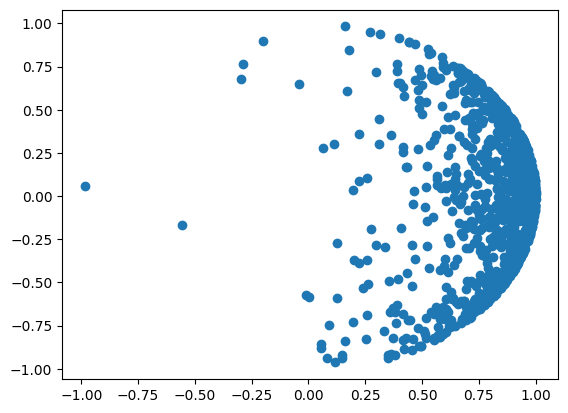

In [34]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
ax.scatter(samples[:, 0].detach().cpu().numpy(), samples[:, 1].detach().cpu().numpy())
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
import math

class MixedCurvatureVAE(nn.Module):
    def __init__(
        self, 
        n_gene, 
        n_batch=None, 
        z_dim=2,
        encoder_layer=None, 
        decoder_layer=None, 
        latent_dist="vmf", 
        observation_dist="nb",
        batch_invariant=False
    ):
        super(MixedCurvatureVAE, self).__init__()
        
        if encoder_layer is None:
            encoder_layer = [128, 64, 32]
        if decoder_layer is None:
            decoder_layer = [32, 128]
        
        self.batch_invariant = batch_invariant
        self.n_input_feature = n_gene
        self.z_dim = z_dim
        self.encoder_layer = encoder_layer
        self.decoder_layer = decoder_layer
        self.latent_dist = latent_dist
        self.observation_dist = observation_dist
        
        if self.latent_dist == "vmf":
            self.z_dim += 1
        
        if not isinstance(n_batch, list):
            n_batch = [n_batch]
        
        self.n_batch = n_batch
        
        self._build_encoder()
        self._build_decoder()
    
    def _build_encoder(self):
        layers = []
        
        input_size = self.n_input_feature
        if not self.batch_invariant:
            input_size += sum(self.n_batch)
        
        in_features = input_size
        for units in self.encoder_layer:
            layers.append(nn.Linear(in_features, units))
            layers.append(nn.BatchNorm1d(units))
            layers.append(nn.ELU())
            in_features = units
        
        self.encoder_hidden = nn.Sequential(*layers)
        
        if self.latent_dist == "normal":
            self.z_mu_layer = nn.Linear(self.encoder_layer[-1], self.z_dim)
            self.z_sigma_square_layer = nn.Linear(self.encoder_layer[-1], self.z_dim)
        elif self.latent_dist == "vmf":
            self.z_mu_layer = nn.Linear(self.encoder_layer[-1], self.z_dim)
            self.z_sigma_square_layer = nn.Linear(self.encoder_layer[-1], 1)
        elif self.latent_dist == "wn":
            self.z_mu_layer = nn.Linear(self.encoder_layer[-1], self.z_dim)
            self.z_sigma_square_layer = nn.Linear(self.encoder_layer[-1], self.z_dim)
        else:
            raise NotImplementedError()
    
    def _build_decoder(self):
        layers = []
        
        input_size = self.z_dim + sum(self.n_batch)
        
        in_features = input_size
        for units in self.decoder_layer:
            layers.append(nn.Linear(in_features, units))
            layers.append(nn.BatchNorm1d(units))
            layers.append(nn.ELU())
            in_features = units
        
        self.decoder_hidden = nn.Sequential(*layers)
        
        self.mu_layer = nn.Linear(self.decoder_layer[-1], self.n_input_feature)
        self.sigma_square_layer = nn.Linear(self.decoder_layer[-1], self.n_input_feature)
    
    def multi_one_hot(self, index_tensor, depth_list):
        # Convert multiple batch indices to one-hot encodings
        batch_size = index_tensor.size(0)
        one_hot_tensor = torch.zeros(batch_size, sum(depth_list), device=index_tensor.device)
        
        start_idx = 0
        for col in range(len(depth_list)):
            indices = index_tensor[:, col]
            for i in range(batch_size):
                if indices[i] < depth_list[col]:
                    one_hot_tensor[i, start_idx + indices[i]] = 1
            start_idx += depth_list[col]
        
        return one_hot_tensor
    
    def _encoder(self, x, batch):
        if self.observation_dist == "nb":
            x = torch.log1p(x)
            
            if self.latent_dist == "vmf":
                x = F.normalize(x, p=2, dim=-1)
        
        if not self.batch_invariant:
            x = torch.cat([x, batch], dim=1)
        
        h = self.encoder_hidden(x)
        
        if self.latent_dist == "normal":
            z_mu = self.z_mu_layer(h)
            z_sigma_square = F.softplus(self.z_sigma_square_layer(h))
        elif self.latent_dist == "vmf":
            z_mu = self.z_mu_layer(h)
            z_mu = F.normalize(z_mu, p=2, dim=-1)
            z_sigma_square = F.softplus(self.z_sigma_square_layer(h)) + 1
            z_sigma_square = torch.clamp(z_sigma_square, 1, 10000)
        elif self.latent_dist == "wn":
            z_mu = self.z_mu_layer(h)
            z_mu = self._polar_project(z_mu)
            z_sigma_square = F.softplus(self.z_sigma_square_layer(h))
        else:
            raise NotImplementedError
        
        return z_mu, z_sigma_square
    
    def _decoder(self, z, batch):
        z = torch.cat([z, batch], dim=1)
        
        h = self.decoder_hidden(z)
        
        if self.observation_dist == "nb":
            mu = F.softmax(self.mu_layer(h), dim=1)
            mu = mu * self.library_size
            
            sigma_square = F.softplus(self.sigma_square_layer(h))
            sigma_square = torch.mean(sigma_square, dim=0)
        else:
            mu = self.mu_layer(h)
            sigma_square = F.softplus(self.sigma_square_layer(h))
        
        sigma_square = torch.clamp(sigma_square, self.EPS, self.MAX_SIGMA_SQUARE)
        
        return mu, sigma_square
    
    def _clip_min_value(self, x, eps=1e-6):
        return F.relu(x - eps) + eps
    
    def _polar_project(self, x):
        x_norm = torch.sum(torch.square(x), dim=1, keepdim=True)
        x_norm = torch.sqrt(self._clip_min_value(x_norm))
        
        x_unit = x / x_norm
        x_norm = torch.clamp(x_norm, 0, 32)
        
        z = torch.cat([
            torch.cosh(x_norm), 
            torch.sinh(x_norm) * x_unit
        ], dim=1)
        
        return z
    
    def _depth_regularizer(self, x, batch):
        with torch.no_grad():
            rate = x * 0.2
            samples = torch.poisson(rate)
        
        x_perturbed = F.relu(x - samples)
        z_mu_hat, _ = self._encoder(x_perturbed, batch)
        
        mean_diff = torch.sum(torch.pow(self.z_mu - z_mu_hat, 2), dim=1)
        loss = torch.mean(mean_diff)
        
        return loss
    
    def log_likelihood_nb(self, x, mu, sigma_square, eps=1e-10):
        log_theta_mu_eps = torch.log(sigma_square + mu + eps)
        res = (
            torch.lgamma(x + sigma_square) - torch.lgamma(x + 1) - torch.lgamma(sigma_square) +
            sigma_square * (torch.log(sigma_square) - log_theta_mu_eps) +
            x * (torch.log(mu) - log_theta_mu_eps)
        )
        return res
    
    def log_likelihood_student(self, x, mu, sigma_square, df=5.0):
        df_halved = df / 2
        return (
            torch.lgamma(df_halved + 0.5) - torch.lgamma(df_halved) -
            0.5 * torch.log(math.pi * df * sigma_square) -
            (df_halved + 0.5) * torch.log(1 + (x - mu)**2 / (df * sigma_square))
        )
    
    def forward(self, x, batch_id):
        if len(self.n_batch) > 1:
            batch = self.multi_one_hot(batch_id, self.n_batch)
        else:
            batch = F.one_hot(batch_id, self.n_batch[0]).float()
        
        self.library_size = torch.sum(x, dim=1, keepdim=True)
        
        self.z_mu, self.z_sigma_square = self._encoder(x, batch)
        
        # Sample latent variable
        if self.latent_dist == "normal":
            self.q_z = dist.Normal(self.z_mu, torch.sqrt(self.z_sigma_square))
            self.z = self.q_z.rsample()
            self.p_z = dist.Normal(torch.zeros_like(self.z), torch.ones_like(self.z))
            kl = dist.kl_divergence(self.q_z, self.p_z).sum(dim=1)
            self.kl = torch.mean(kl)
        elif self.latent_dist == 'vmf':
            self.q_z = VonMisesFisher(self.z_mu, self.z_sigma_square)
            self.z = self.q_z.sample()
            self.p_z = HypersphericalUniform(self.z_dim - 1, dtype=x.dtype)
            kl = self.q_z.kl_divergence(self.p_z)
            self.kl = torch.mean(kl)
        elif self.latent_dist == 'wn':
            self.q_z = HyperbolicWrappedNorm(self.z_mu, self.z_sigma_square)
            self.z = self.q_z.sample()
            tmp = self._polar_project(torch.zeros_like(self.z_sigma_square))
            self.p_z = HyperbolicWrappedNorm(tmp, torch.ones_like(self.z_sigma_square))
            kl = self.q_z.log_prob(self.z) - self.p_z.log_prob(self.z)
            self.kl = torch.mean(kl)
        else:
            raise NotImplementedError
        
        # Decoder
        self.mu, self.sigma_square = self._decoder(self.z, batch)
        
        # Depth regularization
        self.depth_loss = self._depth_regularizer(x, batch)
        
        # ELBO calculation
        if